In [16]:
import pandas as pd
import numpy as np

In [18]:
# ============================================================
# LOAD DATA
# ============================================================

df_fwd = pd.read_excel("A.xlsx", sheet_name="NBP Forwards", parse_dates=["Date"])
df_da  = pd.read_excel("A.xlsx", sheet_name="NBP Outturn", parse_dates=["Date"])

In [19]:
# ======================================================
# REPORTING MONTHS
# ======================================================
reporting_months = pd.date_range(
    start="2024-04-01",
    end="2026-03-01",
    freq="MS"
).to_list()

first_rm = reporting_months[0]   # 2024-04-01

In [20]:
# ======================================================
# SEASONS TO OPTIMISE
# ======================================================
SEASONS = {
    "S24": {
        "exposure":        100_000,
        "starting_volume":  80_000,
        "demand":          100_000,
        "starting_wap":    156.0,
        "horizon":         pd.Timestamp("2024-03-01"),  # hedged before 1-Apr-24
        "delivery_end":    pd.Timestamp("2024-09-01"),  # LAST reporting month: 1-Oct-24
        "optimise":        False
    },
    "W24": {
        "exposure":        150_000,
        "starting_volume": 108_000,
        "demand":          150_000,
        "starting_wap":    139.0,
        "horizon":         pd.Timestamp("2024-09-01"),  # last hedge: 1-Sep-24
        "delivery_end":    pd.Timestamp("2025-03-01"),  # LAST reporting month: 1-Apr-25
        "optimise":        True
    },
    "S25": {
        "exposure":        100_000,
        "starting_volume":  39_000,
        "demand":          100_000,
        "starting_wap":    101.0,
        "horizon":         pd.Timestamp("2025-03-01"),  # last hedge: 1-Mar-25
        "delivery_end":    pd.Timestamp("2025-09-01"),  # LAST reporting month: 1-Oct-25
        "optimise":        True
    },
    "W25": {
        "exposure":        150_000,
        "starting_volume":   9_000,
        "demand":          150_000,
        "starting_wap":    106.0,
        "horizon":         pd.Timestamp("2025-09-01"),
        "delivery_end":    pd.Timestamp("2026-03-01"),  # 1-Apr-26
        "optimise":        True
    },
}


In [3]:
# ======================================================
# WAP CALCULATION
# ======================================================
def compute_wap(hedge_df: pd.DataFrame, season: str, starting_wap: float) -> pd.DataFrame:
    waps = []
    wap = starting_wap
    prev_vol = hedge_df["HedgeVolume"].iloc[0]

    for i, row in hedge_df.iterrows():
        vol = row["HedgeVolume"]
        inc = row["Increment"]

        # rows with no volume (post-delivery) → blank WAP
        if pd.isna(vol):
            waps.append(np.nan)
            continue

        if i == 0:
            # first row (1-Apr-24) → starting WAP, no trade
            waps.append(wap)
            continue

        if inc > 0:
            px_series = df_fwd.loc[df_fwd["Date"] <= row["ReportingMonth"], season]
            if px_series.empty:
                exec_px = df_fwd[season].dropna().iloc[0]
            else:
                exec_px = px_series.iloc[-1]

            wap = (wap * prev_vol + exec_px * inc) / vol

        waps.append(wap)
        prev_vol = vol

    hedge_df["WAP"] = waps
    return hedge_df

In [4]:
# ======================================================
# MtM CALCULATION
# ======================================================
def compute_mtm(hedge_df, season, horizon, delivery_end):
    mtm_vals = []

    for i, row in hedge_df.iterrows():
        rm = row["ReportingMonth"]      # reporting month (1-Apr-24, 1-May-24, ...)
        vol = row["HedgeVolume"]
        wap = row["WAP"]

        # Blank row or missing WAP/Volume → blank MtM
        if pd.isna(vol) or pd.isna(wap):
            mtm_vals.append(np.nan)
            continue

        # First row (1-Apr-24) → no MtM
        if rm.month == 4 and rm.year == 2024:
            mtm_vals.append(np.nan)
            continue

        # Identify previous month window EXACTLY like Excel
        prev_month_start = (rm - pd.DateOffset(months=1)).replace(day=1)
        prev_month_end   = rm.replace(day=1) - pd.Timedelta(days=1)

        # =====================================================
        # PRE-DELIVERY → use FORWARD AVERAGE for prev month
        # =====================================================
        if rm <= horizon:
            mask = (
                (df_fwd["Date"] >= prev_month_start) &
                (df_fwd["Date"] <= prev_month_end)
            )
            window = df_fwd.loc[mask, season]

            if window.empty:
                mtm_vals.append(np.nan)
            else:
                avg_fwd = window.mean()
                mtm = ((wap - avg_fwd) * vol) / 100
                mtm_vals.append(mtm)
            continue

        # =====================================================
        # DELIVERY PERIOD → use OUTTURN AVERAGE for prev month
        # =====================================================
        if rm <= delivery_end:
            mask = (
                (df_da["Date"] >= prev_month_start) &
                (df_da["Date"] <= prev_month_end)
            )
            window = df_da.loc[mask, "DA"]

            if window.empty:
                mtm_vals.append(np.nan)
            else:
                avg_da = window.mean()
                mtm = ((wap - avg_da) * vol) / 100
                mtm_vals.append(mtm)
            continue

        # =====================================================
        # POST-DELIVERY → always blank
        # =====================================================
        mtm_vals.append(np.nan)

    hedge_df["MtM"] = mtm_vals
    return hedge_df


In [21]:
# ======================================================
# CELL 3 — GLOBAL HEDGE OPTIMISATION ENGINE
# ======================================================

# ------------------------------------------------------
# PARAMETER GRID (adjust as needed)
# ------------------------------------------------------
VOL_WINDOWS      = [20, 30, 45, 60]
LOW_TRIGGERS     = [0.70, 0.80, 0.90]
HIGH_TRIGGERS    = [1.10, 1.20, 1.30]
LOW_MULTIPLIERS  = [1.2, 1.5, 2.0]
HIGH_MULTIPLIERS = [0.5, 0.7, 0.9]
HEDGE_TARGETS = [0.50, 0.60, 0.70, 0.80, 0.90, 1.0]   


# ------------------------------------------------------
# 1. RUN A MULTI VOLATILITY-BASED HEDGE SCENARIO
# ------------------------------------------------------
def run_vol_scenario(season, base_params,
                     vol_window, low_trig, high_trig,
                     low_mult, high_mult, hedge_target):
    """
    Executes volatility-based hedging for ONE season using ONE
    universal parameter set.
    Returns hedge dataframe with ReportingMonth, HedgeVolume, Increment, WAP, MtM.
    """

    horizon      = base_params["horizon"]
    delivery_end = base_params["delivery_end"]
    start_vol    = base_params["starting_volume"]
    target_vol   = hedge_target * base_params["demand"]
    starting_wap = base_params["starting_wap"]

    # Forward curve subset
    s = df_fwd[["Date", season]].dropna().copy()
    s["Returns"] = s[season].pct_change()
    s["Vol"]     = s["Returns"].rolling(vol_window).std().bfill().ffill()

    avg_vol = s["Vol"].mean()

    # Hedging months
    hedge_months = [rm for rm in reporting_months if first_rm < rm <= horizon]
    n_steps      = len(hedge_months)
    base_inc     = (target_vol - start_vol) / n_steps if n_steps > 0 else 0

    rows = []
    vol_curr = start_vol

    for rm in reporting_months:

        # Starting snapshot
        if rm == first_rm:
            rows.append([rm, vol_curr, 0.0])
            continue

        # PRE-DELIVERY HEDGING
        if rm <= horizon:
            subset = s[s["Date"] <= rm]
            vol_today = subset["Vol"].iloc[-1] if not subset.empty else avg_vol

            # volatility-driven increment
            if vol_today < avg_vol * low_trig:
                inc = base_inc * low_mult
            elif vol_today > avg_vol * high_trig:
                inc = base_inc * high_mult
            else:
                inc = base_inc

            # do not overshoot target
            inc = max(0, min(inc, target_vol - vol_curr))
            vol_curr += inc

            rows.append([rm, vol_curr, inc])
            continue

        # IN DELIVERY
        if rm <= delivery_end:
            vol_curr = target_vol
            rows.append([rm, vol_curr, 0.0])
            continue

        # POST-DELIVERY → blank
        rows.append([rm, np.nan, np.nan])

    hedge = pd.DataFrame(rows, columns=["ReportingMonth", "HedgeVolume", "Increment"])

    # Add WAP and MtM
    hedge = compute_wap(hedge, season, starting_wap)
    hedge = compute_mtm(hedge, season, horizon, delivery_end)

    return hedge

In [22]:
# ------------------------------------------------------
# 2. SCORING FUNCTION (MtM stability + PnL)
# ------------------------------------------------------
def score_hedge(hedge_df, demand, hedge_target):
    """
    Multi-objective score:
    + Reward high hedge ratio
    + Reward positive PnL
    + Penalise MtM volatility
    + Penalise deviations from hedge target
    """

    mtm = hedge_df["MtM"].dropna()

    if len(mtm) < 3:
        return -1e12

    # --- 1) MtM volatility penalty ---
    mtm_vol = mtm.std()

    # --- 2) Total PnL reward ---
    pnl = mtm.sum()

    # --- 3) Final hedge ratio ---
    final_volume = hedge_df["HedgeVolume"].dropna().iloc[-1]
    hedge_ratio = final_volume / demand

    # --- 4) Penalty for missing target hedge ratio ---
    ratio_penalty = abs(hedge_ratio - hedge_target)

    # --- 5) Brutal penalty for major underhedging ---
    if hedge_ratio < 0.4:
        return -1e9  # forbidden region

    # COMPOSITE SCORE
    score = (
          0.5 * pnl             # reward PnL
        - 1.0 * mtm_vol         # penalise volatility
        - 2.0 * ratio_penalty  # heavily penalise wrong hedge ratio
    )

    return score

In [23]:
# ------------------------------------------------------
# 3. RUN ONE PARAMETER SET ACROSS *ALL* OPTIMISED SEASONS
# ------------------------------------------------------
def run_global_scenario(param_set):
    """
    Runs W24, S25, W25 with the SAME hedging parameters.
    Returns (dict of hedge dfs, total score).
    """

    results = {}
    total_score = 0

    for season in ["W24", "S25", "W25"]:
        p = SEASONS[season]
        hedge = run_vol_scenario(
            season, p,
            vol_window=param_set["vol_window"],
            low_trig=param_set["low_trig"],
            high_trig=param_set["high_trig"],
            low_mult=param_set["low_mult"],
            high_mult=param_set["high_mult"],
            hedge_target=param_set["hedge_target"]
            )

        results[season] = hedge
        total_score += score_hedge(
        hedge_df=hedge,
        demand=p["demand"],
        hedge_target=param_set["hedge_target"]
        )

    return results, total_score

In [24]:

# ------------------------------------------------------
# 4. GLOBAL OPTIMISER
# ------------------------------------------------------
def optimise_global_hedge():
    """
    Searches over all parameter combinations to find
    one universal hedging rule for all seasons.
    """

    history = []
    score_history = []
    best = {"score": -1e20, "params": None, "results": None}

    # GRID SEARCH (correct indentation)
    for htgt in HEDGE_TARGETS:
        for vw in VOL_WINDOWS:
            for lt in LOW_TRIGGERS:
                for ht in HIGH_TRIGGERS:
                    for lm in LOW_MULTIPLIERS:
                        for hm in HIGH_MULTIPLIERS:

                            param_set = {
                                "hedge_target": htgt,
                                "vol_window":   vw,
                                "low_trig":     lt,
                                "high_trig":    ht,
                                "low_mult":     lm,
                                "high_mult":    hm
                            }

                            # Run scenario
                            results, score = run_global_scenario(param_set)

                            # Record score
                            score_history.append(score)

                            # Log for spaghetti plots
                            history.append({
                                "params": param_set,
                                "results": results,
                                "score": score
                            })

                            # Track best
                            if score > best["score"]:
                                best["score"] = score
                                best["params"] = param_set
                                best["results"] = results

    return best, history, score_history

In [6]:
# ======================================================
# VOLATILITY-BASED HEDGE LOGIC
# ======================================================
def build_volatility_hedge(season: str, params: dict) -> pd.DataFrame:
    """
    Returns DF with:
    ReportingMonth, HedgeVolume, Increment
    Only populated up to delivery_end.
    """
    start_vol   = params["starting_volume"]
    target_vol  = hedge_target * params["demand"]
    horizon     = params["horizon"]
    delivery_end= params["delivery_end"]

    # Forward curve
    s = df_fwd[["Date", season]].dropna()
    if s.empty:
        raise ValueError(f"No forward data for {season}")

    s["Returns"] = s[season].pct_change()
    s["Vol"]     = s["Returns"].rolling(30).std().bfill().ffill()
    avg_vol      = s["Vol"].mean()

    low_trig  = 0.75
    high_trig = 1.25

    # Months where we actually hedge (strictly after 1-Apr-24, up to horizon)
    ladder_months = [rm for rm in reporting_months if first_rm < rm <= horizon]
    n_steps       = len(ladder_months)
    total_add     = target_vol - start_vol
    base_inc      = total_add / n_steps if n_steps > 0 else 0.0

    rows = []
    vol_curr = start_vol

    for rm in reporting_months:
        # 1) Starting snapshot: 1-Apr-24 -> show existing, no increment
        # First reporting month (01-Apr-24): show exposure + existing hedge + WAP, but no MtM
        if rm == first_rm:
            rows.append([rm, vol_curr, 0.0])   # Increment is 0. WAP assigned later.
            continue

        # 2) Hedging window: (1-Apr-24, horizon]
        if rm <= horizon:
            subset = s[s["Date"] <= rm]
            vol_today = subset["Vol"].iloc[-1] if not subset.empty else s["Vol"].iloc[0]

            if vol_today < avg_vol * low_trig:
                inc = base_inc * 1.5
            elif vol_today > avg_vol * high_trig:
                inc = base_inc * 0.5
            else:
                inc = base_inc

            inc = max(0.0, min(inc, target_vol - vol_curr))
            vol_curr += inc
            rows.append([rm, vol_curr, inc])
            continue

        # 3) After horizon, but still in reporting window for that season: flat at target volume
        if rm <= delivery_end:
            vol_curr = target_vol
            rows.append([rm, vol_curr, 0.0])
            continue

        # 4) Post-delivery: blanks (NaN) to create that “scalar” shape
        rows.append([rm, np.nan, np.nan])

    df = pd.DataFrame(rows, columns=["ReportingMonth", "HedgeVolume", "Increment"])
    return df

In [7]:
best_global, history, score_history = optimise_global_hedge()
UNIVERSAL = best_global["params"]
print("Selected hedge target:", UNIVERSAL["hedge_target"])


Selected hedge target: 1.0


In [25]:
# ======================================================
# BUILD OUTPUT TABLE IN "LADDER-LIKE" STRUCTURE
# ======================================================
output = pd.DataFrame({"ReportingMonth": reporting_months})

for season, params in SEASONS.items():

    # ----------------------------------------
    # 1. Build hedge table for the season
    # ----------------------------------------
    if params.get("optimise", True):
        hedge = run_vol_scenario(season, params, **UNIVERSAL)
        hedge = compute_wap(hedge, season, params["starting_wap"])
    else:
        # FIXED-HEDGE MODE (e.g., S24)
        valid_months = [rm for rm in reporting_months if rm <= params["delivery_end"]]
        hedge = pd.DataFrame({"ReportingMonth": valid_months})
        hedge["HedgeVolume"] = params["starting_volume"]
        hedge["Increment"]   = 0.0
        hedge["WAP"]         = params["starting_wap"]

    # ----------------------------------------
    # 2. Compute MtM (with proper blanking)
    # ----------------------------------------
    hedge = compute_mtm(
        hedge,
        season,
        params["horizon"],
        params["delivery_end"]
    )

    # ----------------------------------------
    # 3. Merge hedge data into output properly
    # ----------------------------------------
    valid_rms = (output["ReportingMonth"] <= params["delivery_end"])
    valid_len = valid_rms.sum()

    # Exposure only within valid rows
    output.loc[valid_rms, f"{season}_Exposure"] = params["exposure"]
    output.loc[~valid_rms, f"{season}_Exposure"] = np.nan

    # HedgeVolume, WAP, MtM only within season range
    output.loc[valid_rms, f"{season}_HedgeVolume"] = hedge["HedgeVolume"].values[:valid_len]
    output.loc[~valid_rms, f"{season}_HedgeVolume"] = np.nan

    output.loc[valid_rms, f"{season}_WAP"] = hedge["WAP"].values[:valid_len]
    output.loc[~valid_rms, f"{season}_WAP"] = np.nan

    output.loc[valid_rms, f"{season}_MtM"] = hedge["MtM"].values[:valid_len]
    output.loc[~valid_rms, f"{season}_MtM"] = np.nan

In [ ]:
# ======================================================
# REMOVE REPORTING MONTHS WHERE NO SEASON IS ACTIVE
# ======================================================
season_cols = []
for season in SEASONS:
    season_cols += [
        f"{season}_Exposure",
        f"{season}_HedgeVolume",
        f"{season}_WAP",
        f"{season}_MtM"
    ]

mask = output[season_cols].notna().any(axis=1)
output = output.loc[mask].reset_index(drop=True)

# ======================================================
# EXPORT CLEAN OUTPUT
# ======================================================
output.to_excel("Optimised_Hedge_Output.xlsx", index=False)
print("Saved Optimised_Hedge_Output.xlsx")


In [9]:
import openpyxl
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.utils import get_column_letter
from openpyxl import Workbook
# ======================================================
# LOAD OUTPUT PRODUCED BY YOUR OPTIMISATION SCRIPT
# ======================================================

from openpyxl import Workbook
wb = Workbook()
ws = wb.active
ws.title = "Optimised Hedge"

# ======================================================
# WRITE DATAFRAME INTO SHEET (raw table first)
# ======================================================
wb = Workbook()
ws = wb.active
ws.title = "Optimised Hedge"

thin = Side(border_style="thin", color="000000")
border = Border(left=thin, right=thin, top=thin, bottom=thin)

header_font = Font(bold=True)
center = Alignment(horizontal="center", vertical="center")

# Seasons in correct order (including S24)
seasons = [
    ("S24", "S24 – 1st Apr to 30th Sept 24"),
    ("W24", "W24 – 1st Oct to 31st Mar 25"),
    ("S25", "S25 – 1st Apr to 30th Sept 25"),
    ("W25", "W25 – 1st Oct to 31st Mar 26")
]

# ---- Row 1 & 2: headers ----

# A1: Reporting month
ws["A1"] = "Reporting Month"
ws["A1"].font = header_font
ws["A1"].alignment = center
ws.column_dimensions["A"].width = 15

col = 2  # start after reporting month

for season, title in seasons:
    start_col = col
    end_col = col + 3  # 4 columns: Exposure, Volume, WAP, MtM

    # Row 1: merged season title
    ws.merge_cells(start_row=1, start_column=start_col,
                   end_row=1, end_column=end_col)
    c = ws.cell(row=1, column=start_col)
    c.value = title
    c.font = header_font
    c.alignment = center

    # Row 2: sub-headers
    ws.cell(row=2, column=col    , value="Seasonal Customer Exposure (th/d)")
    ws.cell(row=2, column=col + 1, value="Seasonal Hedge Volume (th/d)")
    ws.cell(row=2, column=col + 2, value="Hedge Weighted Average Price (c/th)")
    ws.cell(row=2, column=col + 3, value="Hedge MtM (€)")

    for cc in range(col, col + 4):
        ws.cell(row=2, column=cc).font = header_font
        ws.cell(row=2, column=cc).alignment = center

    col += 4

# ---- Row 3 onwards: data from output ----

start_row = 3
for r_idx, row in enumerate(dataframe_to_rows(output, index=False, header=False), start=start_row):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)
        
# ======================================================
# APPLY BORDERS + FORMATS
# ======================================================

max_row = ws.max_row
max_col = ws.max_column

for r in range(1, max_row+1):
    for c in range(1, max_col+1):
        cell = ws.cell(row=r, column=c)
        cell.border = border

        # Header rows
        if r in (1, 2):
            cell.fill = PatternFill(start_color="D9D9D9", fill_type="solid")
            continue

        # Numeric formatting
        if c == 1:
            cell.number_format = "DD-MMM-YYYY"
        else:
            header_text = ws.cell(row=2, column=c).value

            if not isinstance(header_text, str):
                continue

            if "Exposure" in header_text or "Hedge Volume" in header_text:
                cell.number_format = "#,##0"
            elif "Price" in header_text:
                cell.number_format = "0.00"
            elif "MtM" in header_text:
                cell.number_format = "#,##0.00"

# Auto-fit column widths (safe with merged cells)
for col_idx in range(1, max_col + 1):
    col_letter = get_column_letter(col_idx)
    max_length = 0

    for row_idx in range(1, max_row + 1):
        cell = ws.cell(row=row_idx, column=col_idx)
        value = cell.value
        if value is not None:
            value_str = str(value)
            if len(value_str) > max_length:
                max_length = len(value_str)

    ws.column_dimensions[col_letter].width = max_length + 2
    
# SAVE FILE
wb.save("Optimised_Hedge_Formatted.xlsx")
print("Saved formatted Excel: Optimised_Hedge_Formatted.xlsx")


Saved formatted Excel: Optimised_Hedge_Formatted.xlsx


In [10]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")


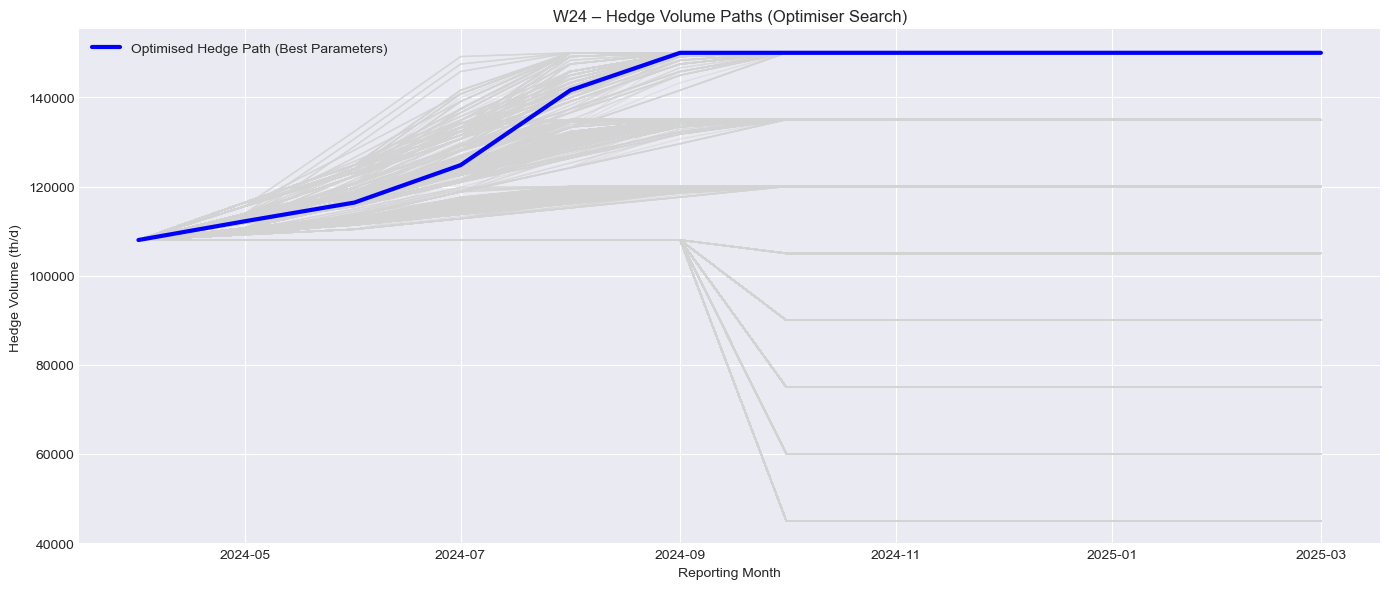

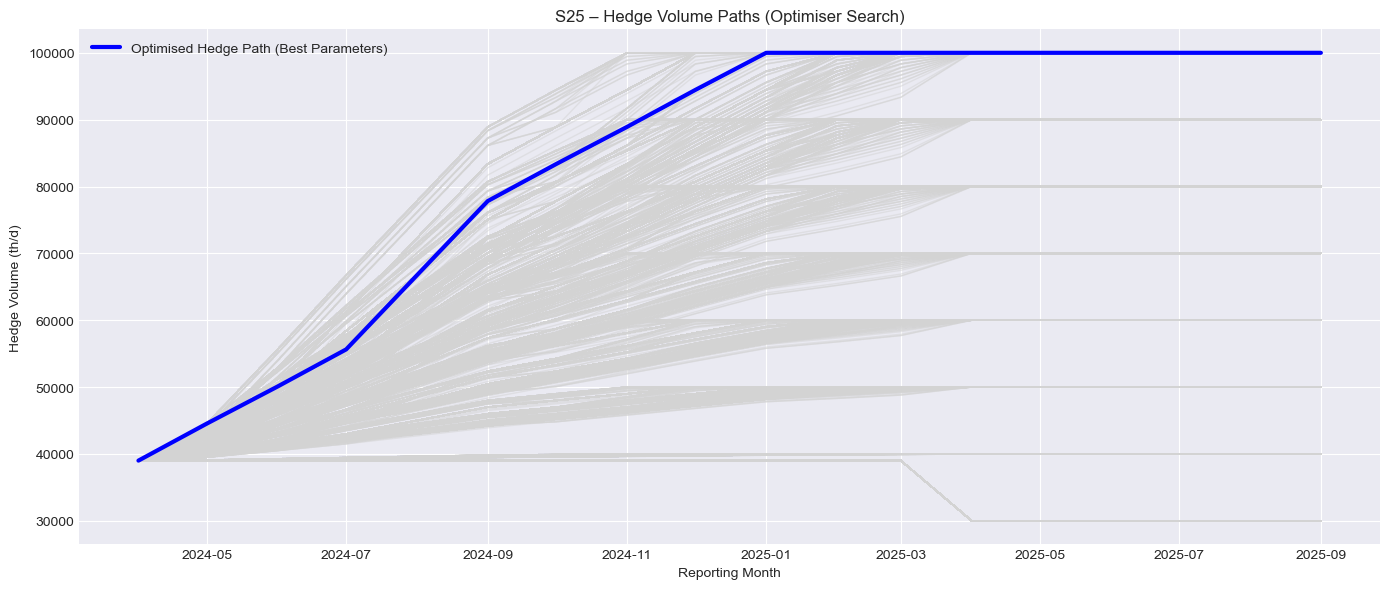

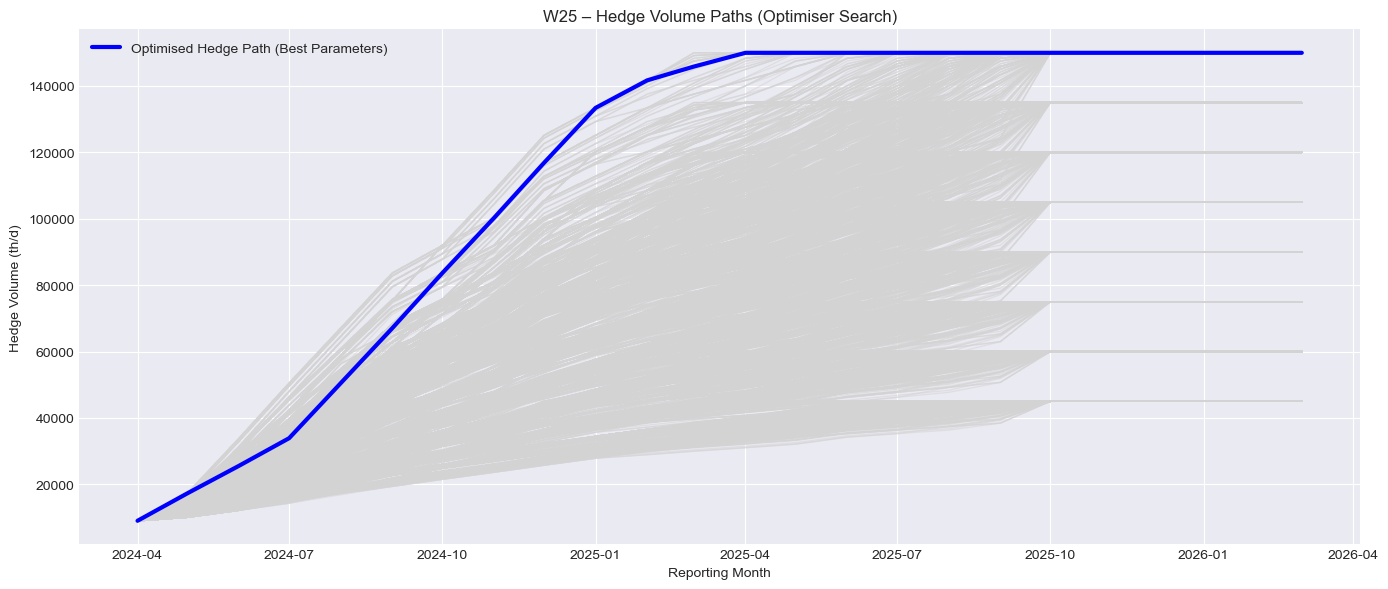

In [10]:
# ======================================================
# SPAGHETTI PLOT OF ALL HEDGE PATHS + OPTIMISED ONE
# ======================================================

import matplotlib.pyplot as plt

def plot_all_runs_for_season(season):
    plt.figure(figsize=(14,6))
    
    # 1. Plot ALL runs (light grey)
    for entry in history:
        hedge = entry["results"][season]
        plt.plot(
            hedge["ReportingMonth"],
            hedge["HedgeVolume"],
            color="lightgrey",
            linewidth=1,
            alpha=0.5
        )
    
    # 2. Plot BEST run (thick blue)
    best_hedge = best_global["results"][season]
    plt.plot(
        best_hedge["ReportingMonth"],
        best_hedge["HedgeVolume"],
        color="blue",
        linewidth=3,
        label="Optimised Hedge Path (Best Parameters)"
    )

    plt.title(f"{season} – Hedge Volume Paths (Optimiser Search)")
    plt.xlabel("Reporting Month")
    plt.ylabel("Hedge Volume (th/d)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Call it for each season
plot_all_runs_for_season("W24")
plot_all_runs_for_season("S25")
plot_all_runs_for_season("W25")


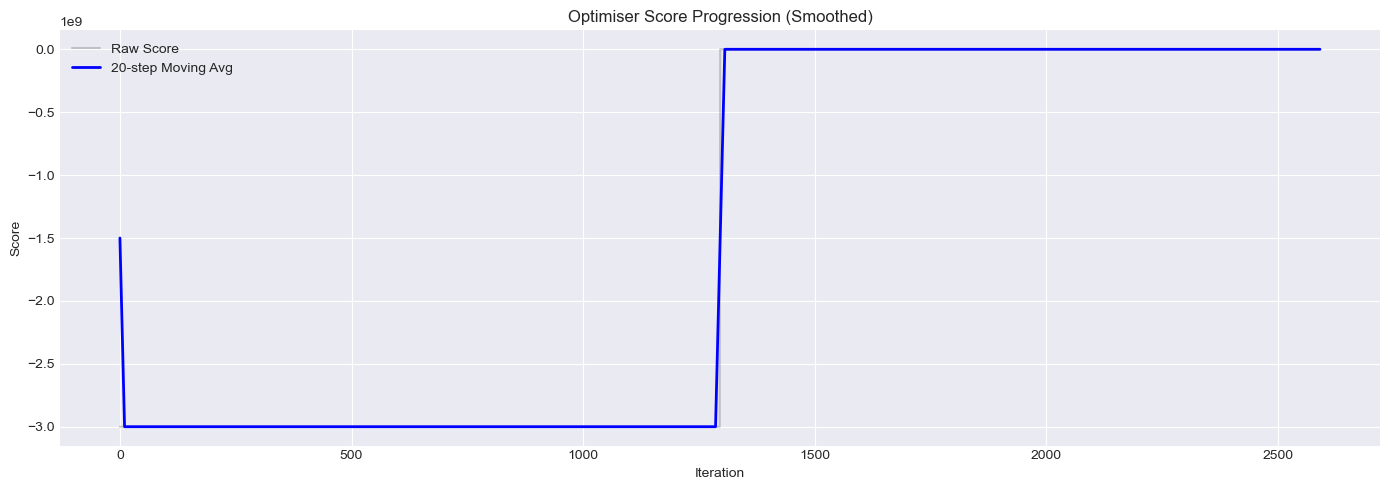

In [11]:
# ======================================================
# PLOT OPTIMISER SCORE PROGRESSION
# ======================================================
import numpy as np

window = 20
smoothed = np.convolve(score_history, np.ones(window)/window, mode="same")

plt.figure(figsize=(14,5))
plt.plot(score_history, alpha=0.4, label="Raw Score", color="grey")
plt.plot(smoothed, linewidth=2, color="blue", label=f"{window}-step Moving Avg")

plt.title("Optimiser Score Progression (Smoothed)")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

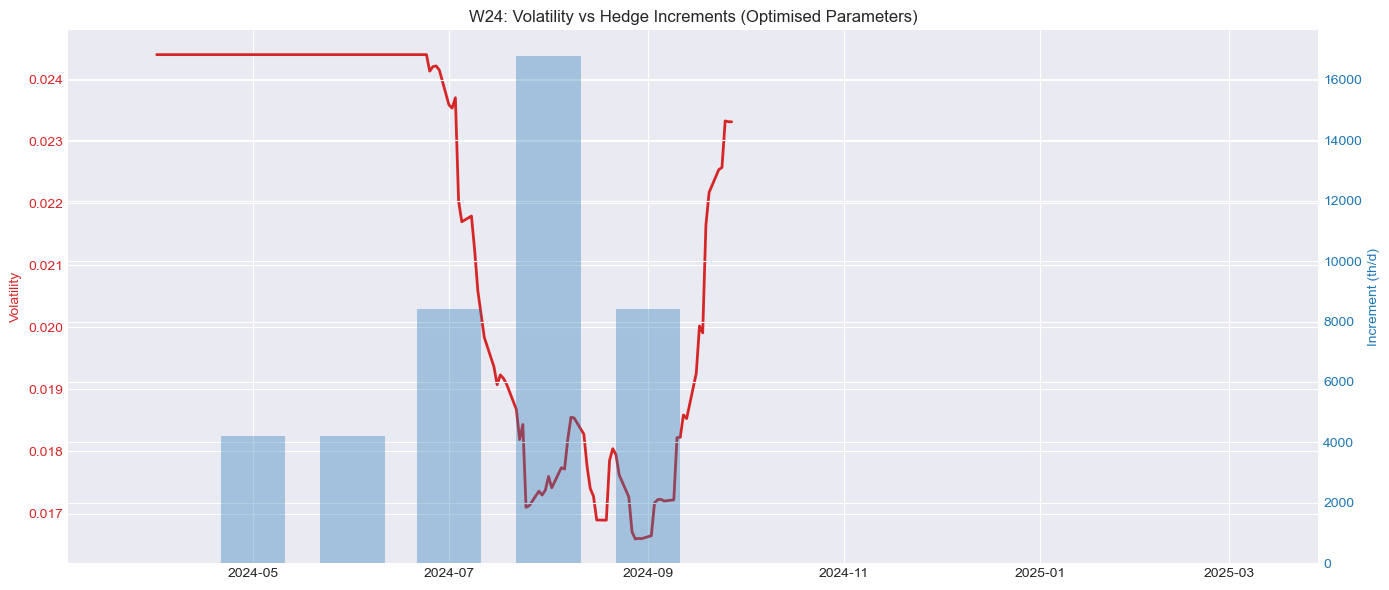

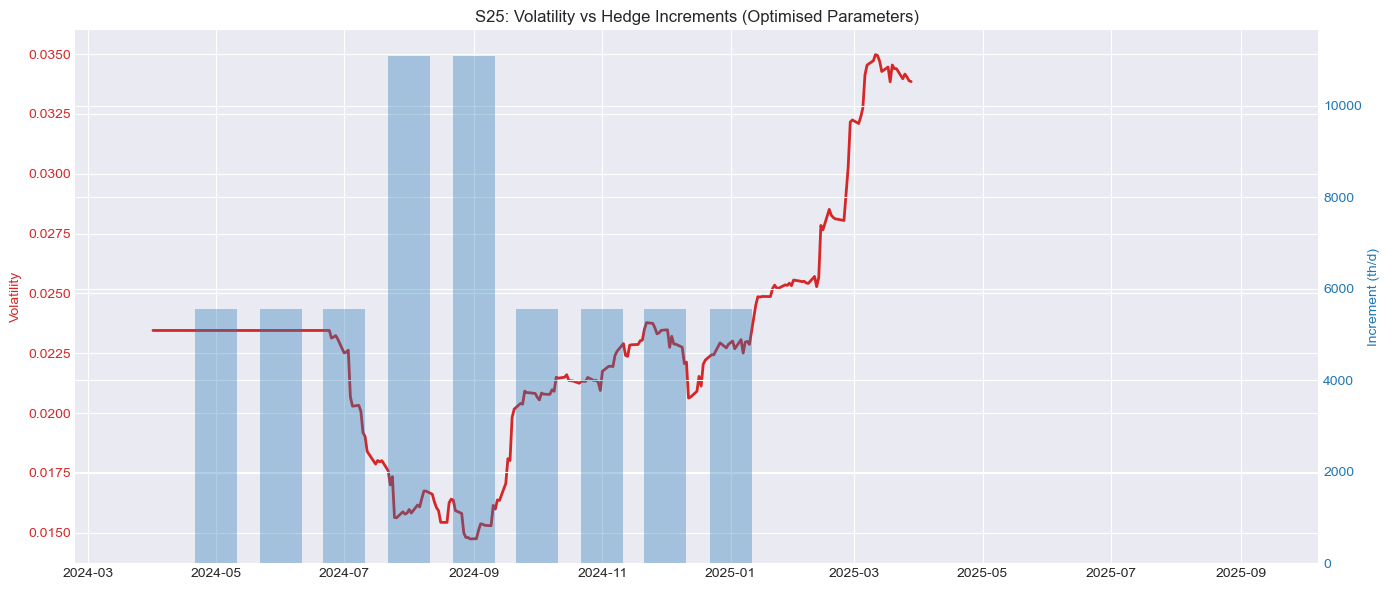

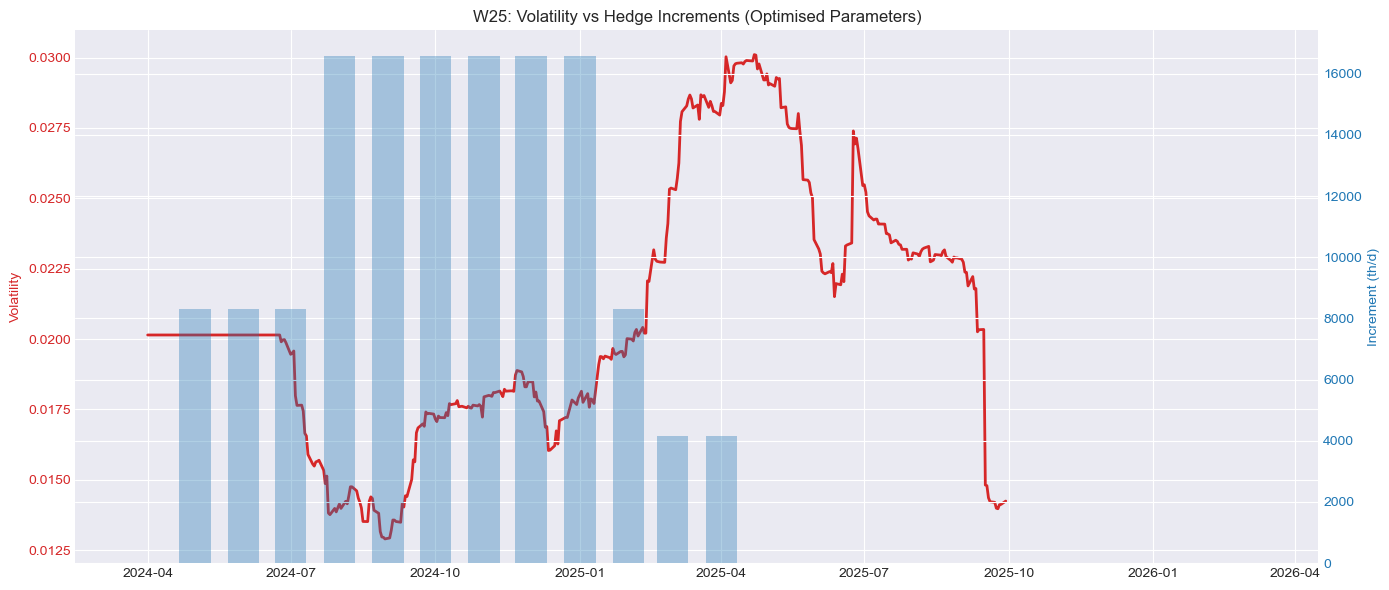

In [11]:
# ======================================================
# VOLATILITY vs HEDGE INCREMENTS FOR ALL SEASONS (OPTIMISED)
# ======================================================

def plot_vol_vs_increment(season):
    params = SEASONS[season]
    UNIV = best_global["params"]

    hedge = run_vol_scenario(season, params, **UNIV)

    # Extract forward prices and compute volatility
    s = df_fwd[["Date", season]].dropna().copy()
    s["Returns"] = s[season].pct_change()
    s["Vol"] = (
        s["Returns"]
        .rolling(UNIV["vol_window"])
        .std()
        .bfill()
        .ffill()
    )

    fig, ax1 = plt.subplots(figsize=(14,6))

    # ---------------------------
    # Rolling Volatility (left y-axis)
    # ---------------------------
    ax1.plot(
        s["Date"], s["Vol"],
        color="tab:red", linewidth=2,
        label=f"{UNIV['vol_window']}-Day Rolling Vol"
    )
    ax1.set_ylabel("Volatility", color="tab:red")
    ax1.tick_params(axis='y', labelcolor="tab:red")

    # ---------------------------
    # Hedge Increments (right y-axis)
    # ---------------------------
    ax2 = ax1.twinx()
    ax2.bar(
        hedge["ReportingMonth"], hedge["Increment"],
        width=20, alpha=0.35, color="tab:blue",
        label="Hedge Increment"
    )
    ax2.set_ylabel("Increment (th/d)", color="tab:blue")
    ax2.tick_params(axis='y', labelcolor="tab:blue")

    plt.title(f"{season}: Volatility vs Hedge Increments (Optimised Parameters)")
    fig.tight_layout()
    plt.show()


# Run the plot for all optimised seasons
for season in ["W24", "S25", "W25"]:
    plot_vol_vs_increment(season)


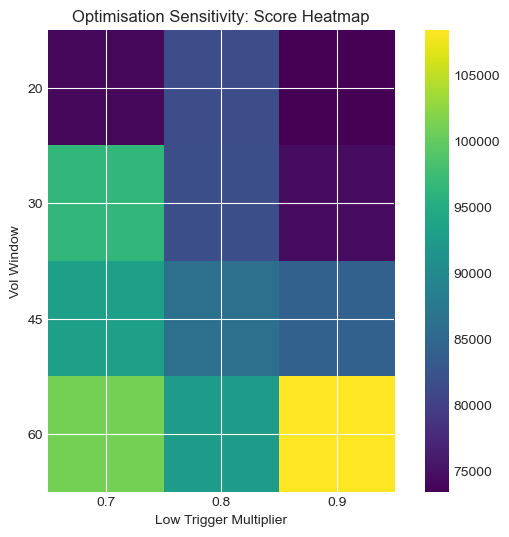

In [13]:
# ============================================
# HEATMAP OF SCORE vs VOL WINDOW & LOW TRIGGER
# ============================================

import numpy as np

heat = np.zeros((len(VOL_WINDOWS), len(LOW_TRIGGERS)))

for i, vw in enumerate(VOL_WINDOWS):
    for j, lt in enumerate(LOW_TRIGGERS):
        
        param_set = {
            "vol_window": vw,
            "low_trig": lt,
            "high_trig": best_global["params"]["high_trig"],
            "low_mult": best_global["params"]["low_mult"],
            "high_mult": best_global["params"]["high_mult"],
            "hedge_target": best_global["params"]["hedge_target"],  

        }
        
        _, score = run_global_scenario(param_set)
        heat[i, j] = score

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(heat, cmap="viridis")

ax.set_xticks(range(len(LOW_TRIGGERS)))
ax.set_yticks(range(len(VOL_WINDOWS)))
ax.set_xticklabels(LOW_TRIGGERS)
ax.set_yticklabels(VOL_WINDOWS)
ax.set_xlabel("Low Trigger Multiplier")
ax.set_ylabel("Vol Window")
ax.set_title("Optimisation Sensitivity: Score Heatmap")

plt.colorbar(im)
plt.show()


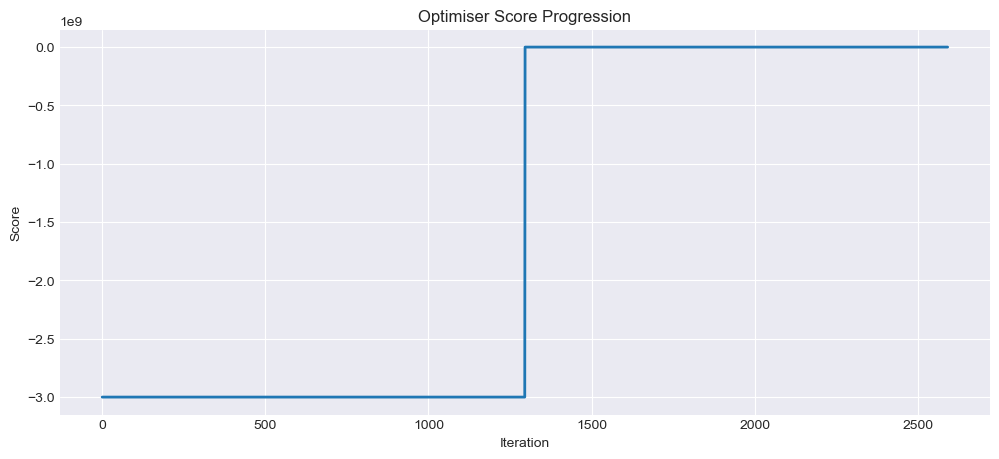

In [14]:
plt.figure(figsize=(12,5))
plt.plot(score_history, linewidth=2)
plt.title("Optimiser Score Progression")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.show()


In [15]:
# ======================================================
# TABLE OF KEY VARIABLES USED IN THE OPTIMISATION + HEDGING MODEL
# ======================================================

from IPython.display import display

# --------------------------
# A. UNIVERSAL PARAMETERS
# --------------------------
univ = best_global["params"]

universal_table = pd.DataFrame({
    "Variable": [
        "vol_window",
        "low_trig",
        "high_trig",
        "low_mult",
        "high_mult"
    ],
    "Description": [
        "Rolling window (days) used for volatility",
        "Low-volatility threshold multiplier",
        "High-volatility threshold multiplier",
        "Multiplier applied to baseline increment in low-vol regime",
        "Multiplier applied to baseline increment in high-vol regime"
    ],
    "Value": [
        univ["vol_window"],
        univ["low_trig"],
        univ["high_trig"],
        univ["low_mult"],
        univ["high_mult"]
    ]
})

print("=== UNIVERSAL OPTIMISED PARAMETERS ===")
display(universal_table)


# --------------------------
# B. SEASON VARIABLES
# --------------------------
season_rows = []

for season, params in SEASONS.items():
    season_rows.append({
        "Season": season,
        "Demand (th/d)": params["demand"],
        "Starting Volume": params["starting_volume"],
        "Target Volume (80%)": hedge_target * params["demand"],
        "Starting WAP (c/th)": params["starting_wap"],
        "Horizon (last hedge month)": params["horizon"],
        "Delivery End (last reporting month)": params["delivery_end"]
    })

season_table = pd.DataFrame(season_rows)

print("\n=== SEASON-SPECIFIC PARAMETERS ===")
display(season_table)


# --------------------------
# C. DERIVED INTERNAL VARIABLES (examples)
# computed from W24 for illustration, but applies to all
# --------------------------
season = "W24"
params = SEASONS[season]

hedge_example = best_global["results"][season]

derived_table = pd.DataFrame({
    "Variable": [
        "avg_vol",
        "base_inc",
        "n_steps",
        "target_volume",
        "final_WAP",
        "final_MtM_sum"
    ],
    "Description": [
        "Mean volatility of rolling returns",
        "Baseline hedging increment per month",
        "Number of hedging months up to horizon",
        "80% demand target volume",
        "Final weighted average hedge price",
        "Total MtM earned during delivery"
    ],
    "Value": [
        df_fwd[season].pct_change().rolling(univ['vol_window']).std().mean(),
        (0.8 * params["demand"] - params["starting_volume"]) / \
            len([rm for rm in reporting_months if first_rm < rm <= params["horizon"]]),
        len([rm for rm in reporting_months if first_rm < rm <= params["horizon"]]),
        0.8 * params["demand"],
        hedge_example["WAP"].dropna().iloc[-1],
        hedge_example["MtM"].dropna().sum()
    ]
})

print("\n=== DERIVED MODEL VARIABLES (Example: W24) ===")
display(derived_table)


=== UNIVERSAL OPTIMISED PARAMETERS ===


,Variable,Description,Value
0,vol_window,Rolling window (days) used for volatility,60.0
1,low_trig,Low-volatility threshold multiplier,0.9
2,high_trig,High-volatility threshold multiplier,1.1
3,low_mult,Multiplier applied to baseline increment in lo...,2.0
4,high_mult,Multiplier applied to baseline increment in hi...,0.5


NameError: name 'hedge_target' is not defined